# F1 lap time predction - tire strategy

### 1. Import Libraries

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn Components
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Machine Learning Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Additional Libraries
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

#### 1.1 Display all column in dataframe

In [2]:
# Set display limit columns in the dataframe to 40. To visualize all columns instead of "..." in between them
pd.set_option('display.max_columns', None)

# set display limit columns in the dataframe to 100. To visualize all rows instead of "..." in between
pd.set_option('display.max_rows', 200)

### 2. Prepare database and Preprocessing

#### 2.1 Load dataframe

In [3]:
# Load the dataset
file_path = '../raw_data/df_all_races.csv'
all_races_df = pd.read_csv(file_path)

In [4]:
all_races_df.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,Sector2SessionTime,Sector3SessionTime,SpeedI1,SpeedI2,SpeedFL,SpeedST,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,Event_Year,GrandPrix,Delta_Lap
0,0 days 01:04:15.340000,VER,1,100.236,1.0,1.0,NaN,NaN,NaN,42.325,24.389,NaN,3831.046,3855.427,230.0,254.0,274.0,250.0,False,SOFT,4.0,False,Red Bull Racing,0 days 01:02:34.872000,2022-03-20 15:03:34.889,1,2.0,False,NaN,False,False,23.9,25.0,1010.2,False,29.1,20,0.5,2022,Bahrain,0.000
1,0 days 01:05:53.220000,VER,1,97.880,2.0,1.0,NaN,NaN,31.285,42.269,24.326,3886.662,3928.931,3953.257,NaN,252.0,276.0,296.0,True,SOFT,5.0,False,Red Bull Racing,0 days 01:04:15.340000,2022-03-20 15:05:15.357,1,2.0,False,NaN,False,True,23.8,26.0,1010.4,False,29.0,357,0.5,2022,Bahrain,-2.356
2,0 days 01:07:31.577000,VER,1,98.357,3.0,1.0,NaN,NaN,31.499,42.474,24.384,3984.756,4027.230,4051.614,229.0,254.0,276.0,294.0,False,SOFT,6.0,False,Red Bull Racing,0 days 01:05:53.220000,2022-03-20 15:06:53.237,1,2.0,False,NaN,False,True,23.8,27.0,1010.4,False,29.0,12,0.5,2022,Bahrain,0.477
3,0 days 01:09:10.143000,VER,1,98.566,4.0,1.0,NaN,NaN,31.342,42.674,24.550,4082.956,4125.630,4150.180,231.0,250.0,276.0,297.0,False,SOFT,7.0,False,Red Bull Racing,0 days 01:07:31.577000,2022-03-20 15:08:31.594,1,2.0,False,NaN,False,True,23.8,29.0,1010.4,False,28.7,12,0.4,2022,Bahrain,0.209
4,0 days 01:10:49.020000,VER,1,98.877,5.0,1.0,NaN,NaN,31.498,42.854,24.525,4181.678,4224.532,4249.057,229.0,256.0,276.0,293.0,False,SOFT,8.0,False,Red Bull Racing,0 days 01:09:10.143000,2022-03-20 15:10:10.160,1,2.0,False,NaN,False,True,23.8,33.0,1010.4,False,28.5,316,0.4,2022,Bahrain,0.311


#### 2.2 Preprocess Dataframe

In [5]:
# Check each column type
all_races_df.dtypes

Time                   object
Driver                 object
DriverNumber            int64
LapTime               float64
LapNumber             float64
Stint                 float64
PitOutTime             object
PitInTime              object
Sector1Time           float64
Sector2Time           float64
Sector3Time           float64
Sector1SessionTime    float64
Sector2SessionTime    float64
Sector3SessionTime    float64
SpeedI1               float64
SpeedI2               float64
SpeedFL               float64
SpeedST               float64
IsPersonalBest         object
Compound               object
TyreLife              float64
FreshTyre                bool
Team                   object
LapStartTime           object
LapStartDate           object
TrackStatus             int64
Position              float64
Deleted                  bool
DeletedReason          object
FastF1Generated          bool
IsAccurate               bool
AirTemp               float64
Humidity              float64
Pressure  

In [6]:
# Display dataset shape
print("Dataset shape:", all_races_df.shape)

Dataset shape: (67079, 41)


In [7]:
# Verify duplicates
print("Number of duplicates:", all_races_df.duplicated().sum())

Number of duplicates: 0


In [8]:
# Remove first/last laps and pit stops
first_and_last_laps_in_stint_indexes = all_races_df[
    (all_races_df.PitInTime.notna()) |
    (all_races_df.PitOutTime.notna()) |
    (all_races_df.LapNumber == 1.0)].index
all_races_df.drop(first_and_last_laps_in_stint_indexes, inplace=True)

print("Dataset shape:", all_races_df.shape)

Dataset shape: (61446, 41)


In [9]:
# Exclusion of features that are not necessary
drop_columns = [
    'Time', 'DriverNumber', 'PitOutTime', 'PitInTime', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
    'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest', 'FreshTyre', 'Team', 'LapStartTime', 'LapStartDate',
    'TrackStatus', 'Deleted', 'DeletedReason', 'FastF1Generated', 'IsAccurate', 'WindDirection', 'WindSpeed', 'Delta_Lap'
]

new_df = all_races_df.drop(columns=drop_columns, inplace=True)

In [10]:
# Display dataset shape
print("Dataset shape:", all_races_df.shape)

Dataset shape: (61446, 17)


In [11]:
# Checking missing values
print("Missing data per column:")
print(all_races_df.isnull().sum())

Missing data per column:
Driver           0
LapTime        481
LapNumber        0
Stint            0
Sector1Time     92
Sector2Time     85
Sector3Time     82
Compound         0
TyreLife         0
Position        80
AirTemp          0
Humidity         0
Pressure         0
Rainfall         0
TrackTemp        0
Event_Year       0
GrandPrix        0
dtype: int64


In [12]:
# Drop NaN in position column
all_races_df.dropna(subset=['Position'], inplace=True)

print("Dataset shape:", all_races_df.shape)

Dataset shape: (61366, 17)


In [13]:
# Checking once again if missing values in position column no longer exist
print("Missing data per column:")
print(all_races_df.isnull().sum())

Missing data per column:
Driver           0
LapTime        401
LapNumber        0
Stint            0
Sector1Time     12
Sector2Time      5
Sector3Time      2
Compound         0
TyreLife         0
Position         0
AirTemp          0
Humidity         0
Pressure         0
Rainfall         0
TrackTemp        0
Event_Year       0
GrandPrix        0
dtype: int64


In [14]:
# Replace in the Rainfall column, False -> 0 and Ture -> 1
all_races_df.replace({'Rainfall': {False: 0, True: 1}}, inplace=True)

In [15]:
# Identify categorical and numerical columns
numerical_columns = all_races_df.select_dtypes(include=[np.number]).columns
categorical_columns = all_races_df.select_dtypes(include=object).columns

print(f'Numerical columns: \n {numerical_columns}')
print(f'Categorical columns: \n {categorical_columns}')

Numerical columns: 
 Index(['LapTime', 'LapNumber', 'Stint', 'Sector1Time', 'Sector2Time',
       'Sector3Time', 'TyreLife', 'Position', 'AirTemp', 'Humidity',
       'Pressure', 'Rainfall', 'TrackTemp', 'Event_Year'],
      dtype='object')
Categorical columns: 
 Index(['Driver', 'Compound', 'GrandPrix'], dtype='object')


In [16]:
all_races_df.head()

,Driver,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,Compound,TyreLife,Position,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,Event_Year,GrandPrix
1,VER,97.880,2.0,1.0,31.285,42.269,24.326,SOFT,5.0,2.0,23.8,26.0,1010.4,0,29.0,2022,Bahrain
2,VER,98.357,3.0,1.0,31.499,42.474,24.384,SOFT,6.0,2.0,23.8,27.0,1010.4,0,29.0,2022,Bahrain
3,VER,98.566,4.0,1.0,31.342,42.674,24.550,SOFT,7.0,2.0,23.8,29.0,1010.4,0,28.7,2022,Bahrain
4,VER,98.877,5.0,1.0,31.498,42.854,24.525,SOFT,8.0,2.0,23.8,33.0,1010.4,0,28.5,2022,Bahrain
5,VER,98.940,6.0,1.0,31.572,42.759,24.609,SOFT,9.0,2.0,23.7,33.0,1010.4,0,28.3,2022,Bahrain


#### 2.3 Pre-visualization

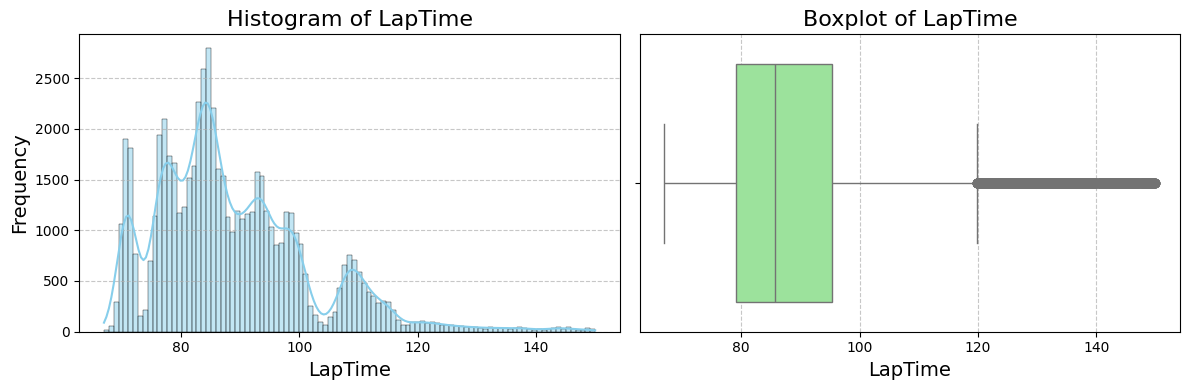

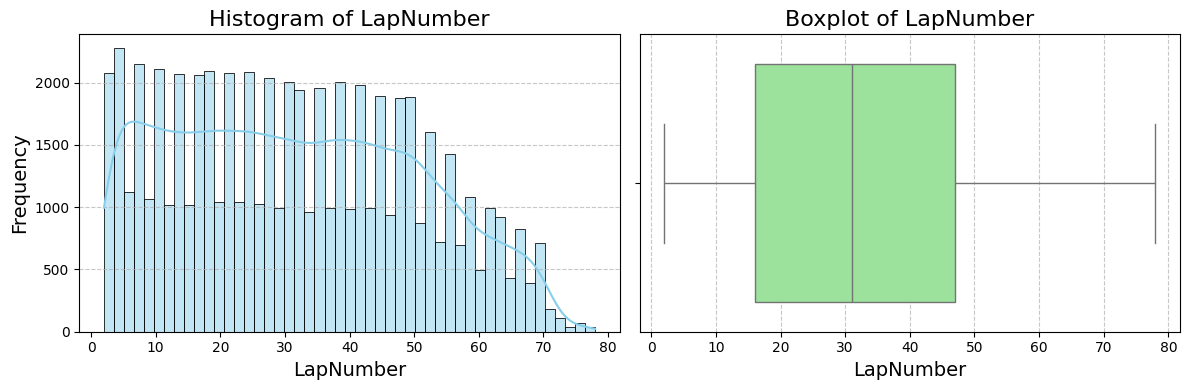

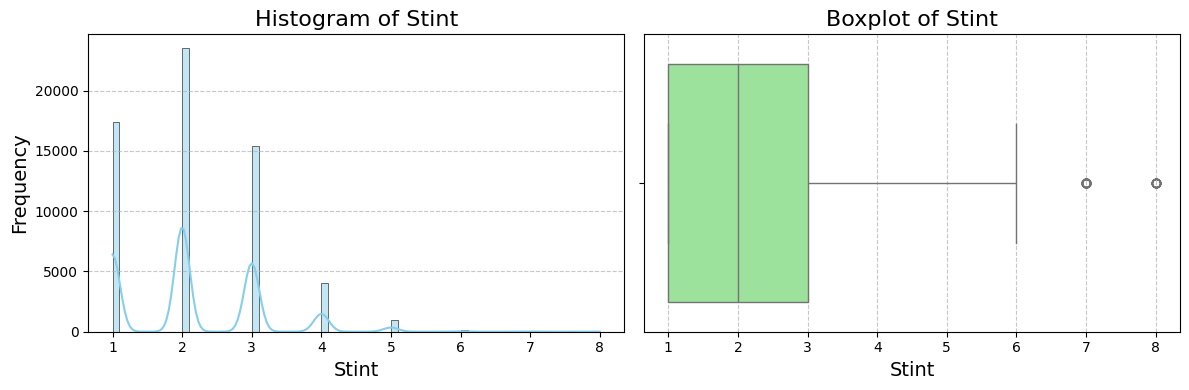

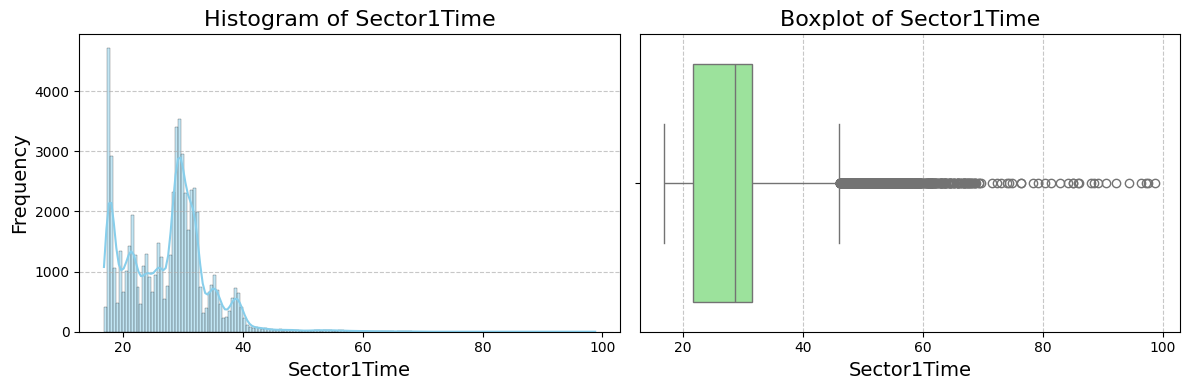

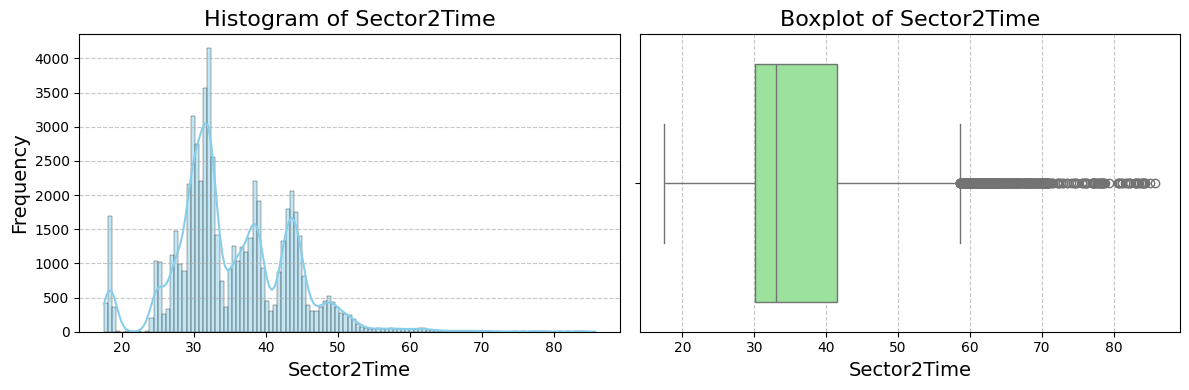

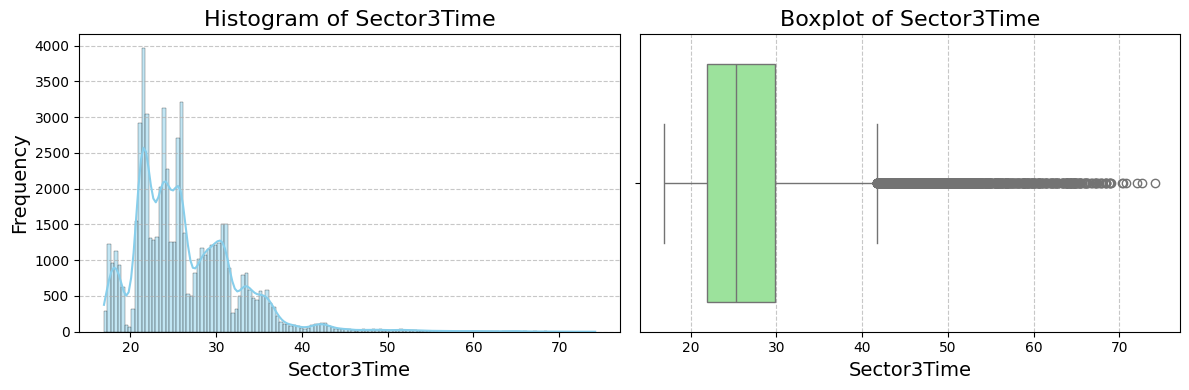

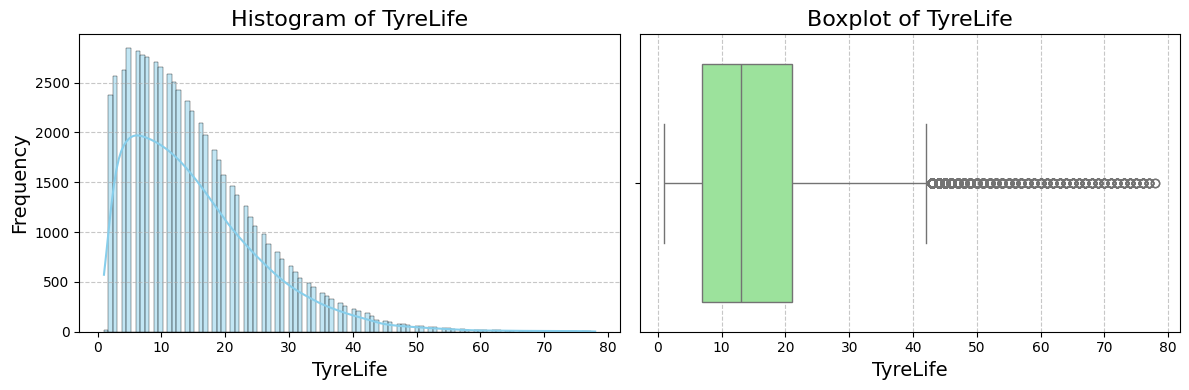

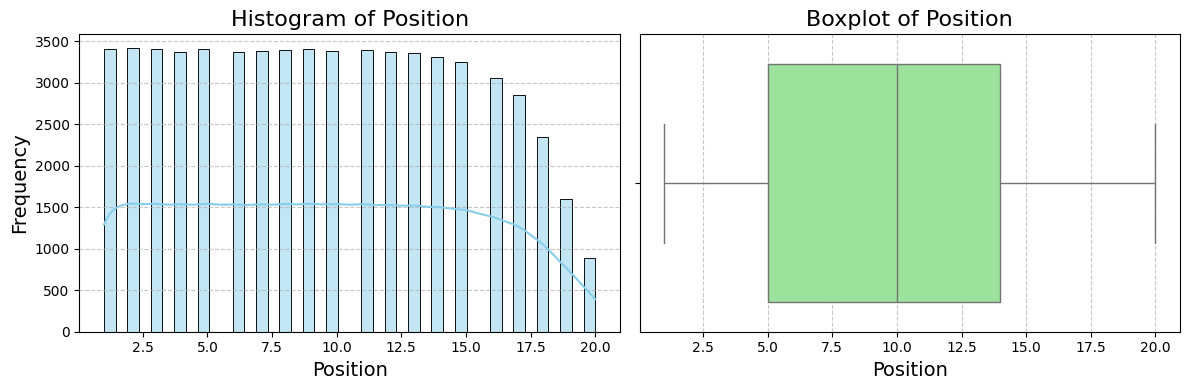

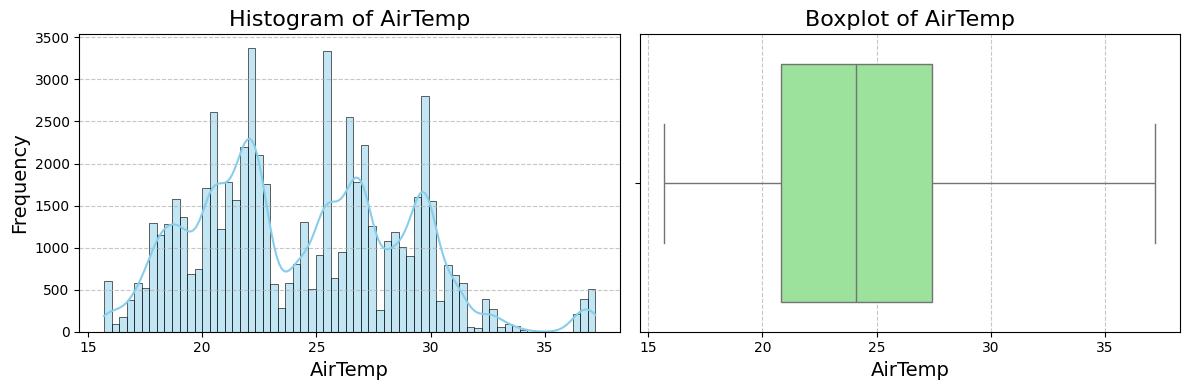

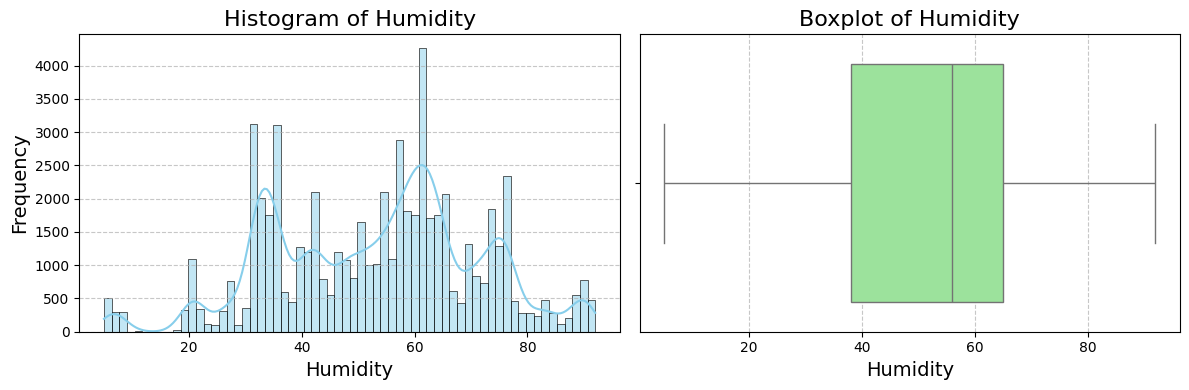

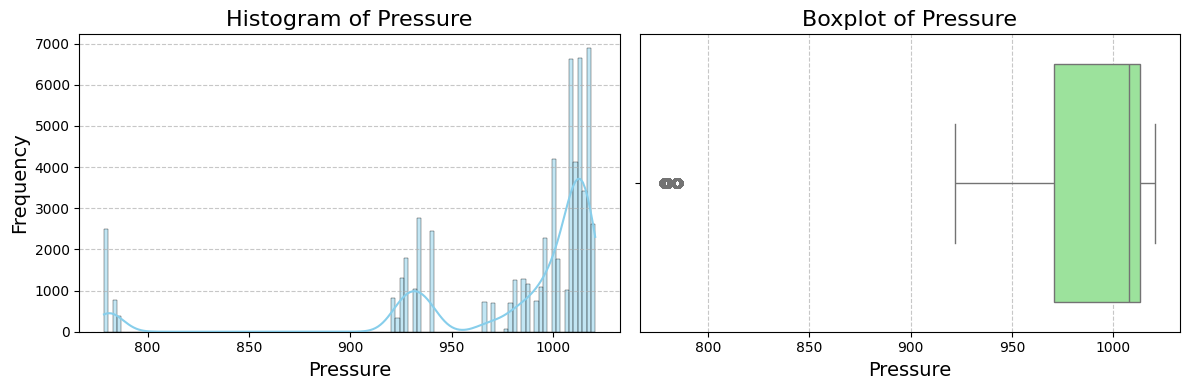

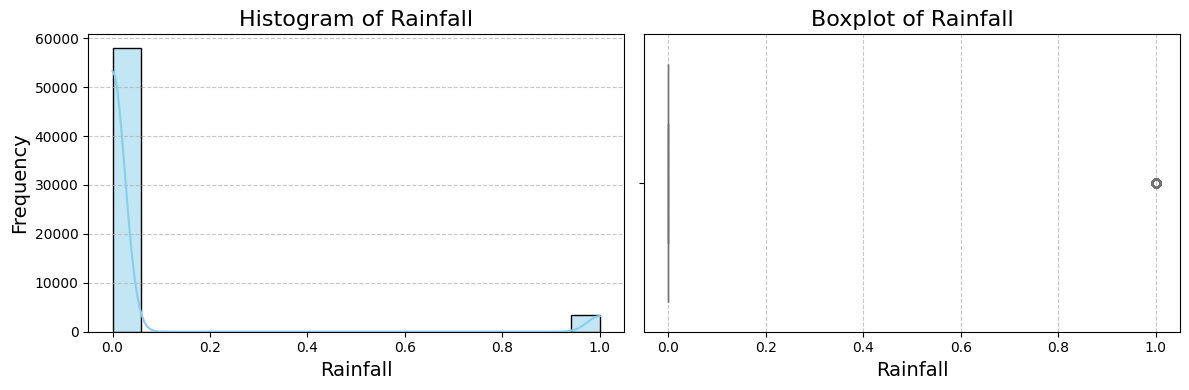

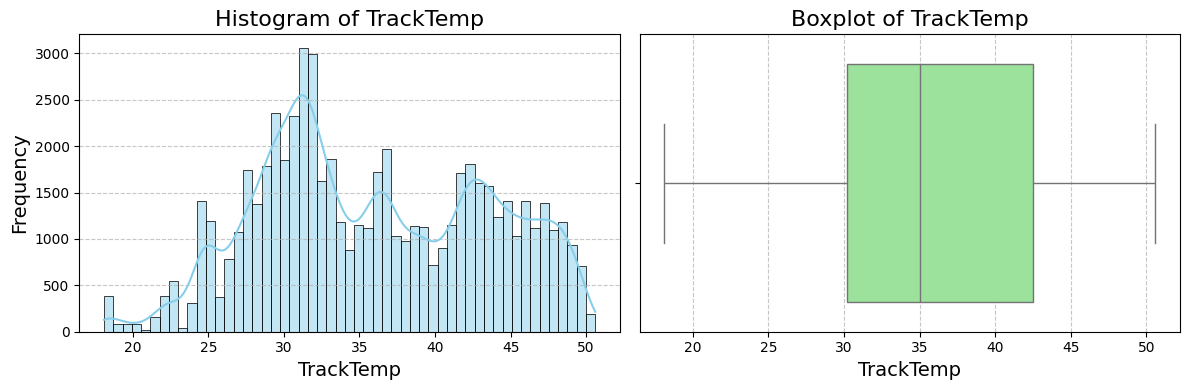

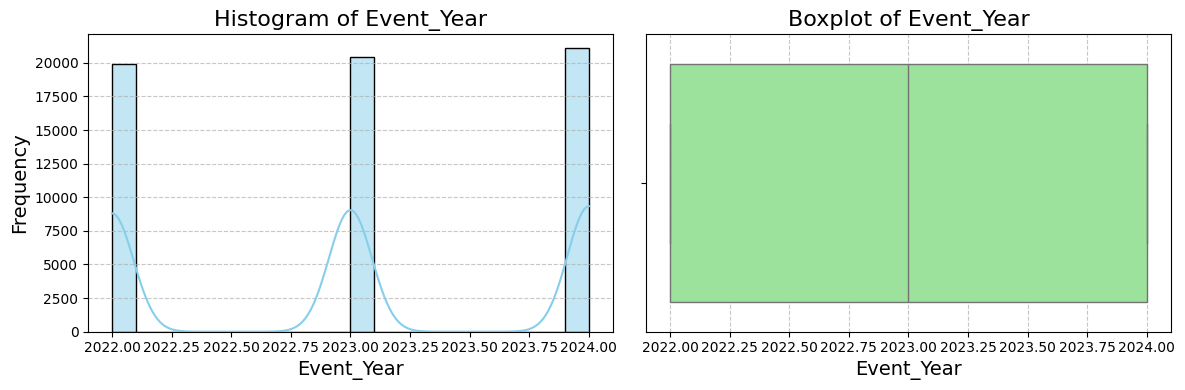

In [17]:
# Define a function to draw a histplot and boxplot graph
def graph(feature):
    # Set up the ppfigure and subplots
    plt.figure(figsize=(12, 4))  # Set the figure size (width, height)

    # Subplot 1: Histogram
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
    sns.histplot(all_races_df[feature], color='skyblue', kde=True)  # Create a histogram with KDE
    plt.title(f'Histogram of {feature}', fontsize=16)  # Add a title
    plt.xlabel(f'{feature}', fontsize=14)  # Label the x-axis
    plt.ylabel('Frequency', fontsize=14)  # Label the y-axis
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better readability

    # Subplot 2: Boxplot
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
    sns.boxplot(x=all_races_df[feature], color='lightgreen')  # Create a boxplot
    plt.title(f'Boxplot of {feature}', fontsize=16)  # Add a title
    plt.xlabel(f'{feature}', fontsize=14)  # Label the x-axis
    plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add gridlines for better readability

    # Adjust layout and display the plot
    plt.tight_layout()  # Automatically adjust subplot spacing
    plt.show()

# for each of numerical features draw a histplot and boxplot graph
for feature in numerical_columns:
    graph(feature)

In [18]:
all_races_df.describe()

,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,TyreLife,Position,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,Event_Year
count,60965.000000,61366.000000,61366.000000,61354.000000,61361.000000,61364.000000,61366.000000,61366.000000,61366.000000,61366.000000,61366.000000,61366.000000,61366.000000,61366.000000
mean,88.769984,31.844116,2.156683,27.504319,35.356586,26.370988,15.359271,9.630479,24.333996,53.193120,980.228812,0.056725,35.901250,2023.019213
std,13.296213,18.614636,0.980445,6.957396,8.098004,6.162938,10.658052,5.356057,4.434766,17.943173,58.368431,0.231319,7.488504,0.816680
min,67.012000,2.000000,1.000000,16.835000,17.488000,16.913000,1.000000,1.000000,15.700000,5.000000,778.500000,0.000000,18.100000,2022.000000
25%,79.183000,16.000000,1.000000,21.613000,30.138000,21.857750,7.000000,5.000000,20.800000,38.000000,971.000000,0.000000,30.200000,2022.000000
50%,85.719000,31.000000,2.000000,28.629000,33.063000,25.258000,13.000000,10.000000,24.100000,56.000000,1007.700000,0.000000,35.000000,2023.000000
75%,95.433000,47.000000,3.000000,31.403750,41.522000,29.812000,21.000000,14.000000,27.400000,65.000000,1013.400000,0.000000,42.500000,2024.000000
max,149.985000,78.000000,8.000000,98.794000,85.756000,74.193000,78.000000,20.000000,37.200000,92.000000,1020.800000,1.000000,50.600000,2024.000000


In [19]:
# Check datafram shape before removing outliers
all_races_df.shape

(61366, 17)

In [20]:
# Remove Outliers from LapTime
# Define a function to exclude outliers before scaling it properly
def exclude_outliers(df, feature):
    """
    Exclude outliers from a feature in a DataFrame using the IQR method.
    """
    # Calculate Q1, Q3, and IQR
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

# Remove outliers from LapTime column
all_races_df = exclude_outliers(all_races_df, 'LapTime')

In [21]:
# Check daframe shape after outliers removed
all_races_df.shape

(59343, 17)

In [22]:
# Preprocess LapNumber as Percentage of the race completed
# First, calculate the max lap number for each unique GrandPrix/Event_Year combination
all_races_df['LapPct'] = all_races_df['LapNumber'] / all_races_df.groupby(['Event_Year', 'GrandPrix'])['LapNumber'].transform('max')

# Display a sample
# all_races_df[['Driver','LapNumber','LapPct','Event_Year','GrandPrix']].head()

### 3. Pipeline (test)

In [23]:
# # StandardScaler Pipeline for numerical features
# num_transf_std = Pipeline([
#     ('imputer', SimpleImputer(strategy='median')),
#     ('standard_scaler', StandardScaler())
# ])

# # MinMaxScaler Pipeline for numerical features
# nun_transf_minmax = Pipeline([
#     ('imputer', SimpleImputer(strategy='median')),
#     ('minmax_scaler', MinMaxScaler())
# ])

# # RobustScaler Pipeline for numerical features
# num_transf_robust = Pipeline([
#     ('imputer', SimpleImputer(strategy='median')),
#     ('robust_scaler', RobustScaler())
# ])

# # RobustScaler & MinMaxSacler Pipeline. Combination of these two methods
# num_transf_combined = Pipeline([
#     ('imputer', SimpleImputer(strategy='median')),
#     ('robust_scaler', RobustScaler()),
#     ('minmax_scaler', MinMaxScaler())
# ])

# # Categorical features Pipeline that will be encoded using OneHotEncoder
# cat_transformer = Pipeline([
#     ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
# ])

# # Create a ColumnTransformer to apply OneHotEncoding and StandardScaler
# numeric_preprocessor = ColumnTransformer(
#     transformers=[
#        #('num_std', num_transf_std, [numerical_columns]),              # StandardScale numerical features
#         ('num_minmax', nun_transf_minmax, ['Position',
#                                            'Stint',
#                                            'TyreLife']),               # MinMaxScale numerical features
#         ('num_robust', num_transf_robust, ['AirTemp',
#                                            'TrackTemp',
#                                            'Humidity',]),              # RobustScale numerical features
#         ('num_combined', num_transf_combined, ['Pressure',
#                                                'Sector1Time',
#                                                'Sector2Time',
#                                                'Sector3Time']),        # Combined two scalers 1° RobustScaler 2° MinMaxScaler
#         ('cat', cat_transformer, ['Driver', 'GrandPrix', 'Compound']), # OneHotEncode categorical features
#         ('passthrough_cols', 'passthrough', ['LapTime', 'LapPct'])     # passthrough means nothings will be done in these columns, it wil copy and paste to the output
#     ],
#     remainder='drop')                                                  # Columns in the original dataframe not mentioned in ColumnTransformer will be dropped

# # Visualizing Pipelines
# numeric_preprocessor

In [24]:
# # fit & transform dataframe
# fitted_all_races = numeric_preprocessor.fit_transform(all_races_df)

# # check dataframe fitted & transformed
# fitted_all_races = pd.DataFrame(fitted_all_races, columns=numeric_preprocessor.get_feature_names_out())

In [25]:
# fitted_all_races.dtypes

In [26]:
# fitted_all_races.describe()

In [27]:
# X = fitted_all_races.drop(columns=[
#     'passthrough_cols__LapTime',
#     'num_combined__Sector1Time',
#     'num_combined__Sector2Time',
#     'num_combined__Sector3Time'
# ])

# y = fitted_all_races['passthrough_cols__LapTime']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# # Initialize models
# models = {
#     "Linear Regression": LinearRegression(),
#     "Ridge": Ridge(),
#     "Lasso": Lasso(),
#     "Random Forest": RandomForestRegressor(random_state=42),
#     "Gradient Boosting": GradientBoostingRegressor(random_state=42),
#     "XGBoost": XGBRegressor(random_state=42),
#     "LightGBM": LGBMRegressor(random_state=42),
#     "SVR": SVR(),
#     "KNN": KNeighborsRegressor()
# }

# # Compare models function
# def compare_models(X_train, y_train, X_test, y_test, models):
#     """
#     Compare multiple regression models using cross-validation and test metrics
#     """
#     results = {}
    
#     for name, model in models.items():
#         cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2', verbose=0) # Training and cross-validation
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
        
#         metrics = {
#             'CV R² Mean': np.mean(cv_scores),
#             'CV R² Std': np.std(cv_scores),
#             'Test R²': r2_score(y_test, y_pred),
#             'MAE': mean_absolute_error(y_test, y_pred),
#             'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
#             'MAPE': np.mean(np.abs((y_test - y_pred) / y_test)) * 100
#         }
        
#         results[name] = metrics
        
#         print(f"\n{name}")
#         print(f"CV R²: {metrics['CV R² Mean']:.4f} (±{metrics['CV R² Std']:.4f})")
#         print(f"Test R²: {metrics['Test R²']:.4f}")
#         print(f"MAE: {metrics['MAE']:.4f}")
    
#     return pd.DataFrame(results).T.sort_values(by='Test R²', ascending=False)

# # Execute model comparison
# results_df = compare_models(X_train, y_train, X_test, y_test, models)

# # Visualization of model performance
# plt.figure(figsize=(12, 6))
# results_df['Test R²'].sort_values().plot(kind='barh')
# plt.title('Comparison of Models by R² Test')
# plt.xlabel('R² Score')
# plt.show()

In [29]:
# # Train final model
# rf = RandomForestRegressor(random_state=42)
# rf.fit(X_train, y_train)

# # Evaluation function
# def evaluate_model(y_true, y_pred, model_name=""):
#     metrics = {
#         'R²': r2_score(y_true, y_pred),
#         'MAE': mean_absolute_error(y_true, y_pred),
#         'RMSE': np.sqrt(mean_squared_error(y_true, y_pred))
#     }
#     print(f"\nModel evaluation {model_name}:")
#     for name, value in metrics.items():
#         print(f"{name}: {value:.4f}")

#     plt.figure(figsize=(10, 6))
#     sns.scatterplot(x=y_true, y=y_pred, alpha=0.4)
#     plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r')
#     plt.xlabel('Real values')
#     plt.ylabel('Predicted Values')
#     plt.title(f'Real vs Predicted - {model_name}')
#     plt.show()

#     return metrics

# # Evaluate
# y_pred = rf.predict(X_test)
# metrics = evaluate_model(y_test, y_pred, "Random Forest")

In [30]:
# # Sample prediction
# new = X.iloc[[0]].copy()
# prediction = rf.predict(new)
# print(f"Predicted lap time: {prediction[0]:.2f} seconds")

#### 3.1 Race Simulation (Driver, Year, Circuit)

In [31]:
# def plot_race_performance(driver, year, grand_prix, df=all_races_df, model=rf, preprocessor=numeric_preprocessor):
#     """
#     Plots lap time evolution with stint information for any driver, year, and circuit.

#     Parameters:
#     -----------
#     driver : str (e.g., 'HAM', 'VER')
#     year : int (e.g., 2023)
#     grand_prix : str (e.g., 'Great Britain')
#     df : DataFrame (default: all_races_df)
#     model : Trained model (default: rf_model)
#     preprocessor : Preprocessing pipeline (default: numeric_preprocessor)
#     """
#     # Filter data
#     race_data = df[
#         (df['Driver'] == driver) &
#         (df['Event_Year'] == year) &
#         (df['GrandPrix'] == grand_prix)
#     ].copy()

#     if race_data.empty:
#         raise ValueError(f"No data found for {driver} at {grand_prix} {year}")

#     # Prepare features and predict
#     features = preprocessor.transform(race_data)
#     features_df = pd.DataFrame(
#         features,
#         columns=preprocessor.get_feature_names_out()
#     )
#     X_race = features_df.drop(columns=[
#         'passthrough_cols__LapTime',
#         'num_combined__Sector1Time',
#         'num_combined__Sector2Time',
#         'num_combined__Sector3Time'
#     ])
#     race_data['PredictedLapTime'] = model.predict(X_race)

#     # Plot
#     fig, ax1 = plt.subplots(figsize=(14, 7))

#     # Primary Axis: Lap Times
#     ax1.plot(
#         race_data['LapNumber'],
#         race_data['LapTime'],
#         label='Actual Lap Time (s)',
#         marker='o',
#         color='blue',
#         linestyle='-',
#         linewidth=2
#     )
#     ax1.plot(
#         race_data['LapNumber'],
#         race_data['PredictedLapTime'],
#         label='Predicted Lap Time (s)',
#         marker='x',
#         color='red',
#         linestyle='--',
#         linewidth=2
#     )
#     ax1.set_xlabel('Lap Number', fontsize=12)
#     ax1.set_ylabel('Lap Time (seconds)', fontsize=12)
#     ax1.grid(True, linestyle='--', alpha=0.7)
#     ax1.legend(loc='upper left')

#     # Secondary Axis: Stints
#     ax2 = ax1.twinx()
#     ax2.plot(
#         race_data['LapNumber'],
#         race_data['Stint'],
#         label='Stint (Pit Stop)',
#         marker='s',
#         color='green',
#         linestyle=':',
#         linewidth=2
#     )
#     ax2.set_ylabel('Stint Number', fontsize=12)
#     ax2.legend(loc='upper right')

#     # Highlight pit stops (stint changes)
#     for i in range(1, len(race_data)):
#         if race_data['Stint'].iloc[i] != race_data['Stint'].iloc[i-1]:
#             ax1.axvline(
#                 x=race_data['LapNumber'].iloc[i],
#                 color='black',
#                 linestyle=':',
#                 alpha=0.5,
#                 label='Pit Stop' if i == 1 else ""
#             )

#     plt.title(f"Lap Time Evolution: {driver} at {grand_prix} {year}\n(Actual vs. Predicted)", fontsize=14)
#     fig.tight_layout()
#     plt.show()

# # Example 1: Hamilton at Bahrain 2024
# plot_race_performance(driver='HAM', year=2024, grand_prix='Great Britain')

# # # Example 2: Verstappen at Bahrain 2024
# # plot_race_performance(driver='VER', year=2024, grand_prix='Great Britain')

# # # Example 3: Leclerc at Bahrain 2024
# # plot_race_performance(driver='LEC', year=2024, grand_prix='Great Britain')

### 4. Pipeline (Projeto)

In [32]:
# StandardScaler Pipeline for numerical features
num_transf_std = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('standard_scaler', StandardScaler())
])

# MinMaxScaler Pipeline for numerical features
nun_transf_minmax = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('minmax_scaler', MinMaxScaler())
])

# RobustScaler Pipeline for numerical features
num_transf_robust = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('robust_scaler', RobustScaler())
])

# RobustScaler & MinMaxSacler Pipeline. Combination of these two methods
num_transf_combined = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('robust_scaler', RobustScaler()),
    ('minmax_scaler', MinMaxScaler())
])

# Categorical features Pipeline that will be encoded using OneHotEncoder
cat_transformer = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Create a ColumnTransformer to apply OneHotEncoding and StandardScaler
numeric_preprocessor = ColumnTransformer(
    transformers=[
        ('num_minmax', nun_transf_minmax, ['Position',
                                           'Stint',
                                           'TyreLife']),               # MinMaxScale numerical features
        ('num_robust', num_transf_robust, ['AirTemp',
                                           'TrackTemp',
                                           'Humidity',]),              # RobustScale numerical features
        ('num_combined', num_transf_combined, ['Pressure',
                                               ]),                     # Combined two scalers 1° RobustScaler 2° MinMaxScaler
        ('cat', cat_transformer, ['Driver', 'GrandPrix', 'Compound']), # OneHotEncode categorical features
    ],
    remainder='drop')                                                  # Columns in the original dataframe not mentioned in ColumnTransformer will be dropped

# Visualizing Pipelines
numeric_preprocessor

ColumnTransformer(transformers=[('num_minmax',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('minmax_scaler',
                                                  MinMaxScaler())]),
                                 ['Position', 'Stint', 'TyreLife']),
                                ('num_robust',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('robust_scaler',
                                                  RobustScaler())]),
                                 ['AirTemp', 'TrackTemp', 'Humidity']),
                                ('num_combined',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('robust_scaler',
                                                  RobustScaler()),
                                                 ('minmax_scaler',
                                                  MinMaxScaler())]),
                                 ['Pressure']),
                                ('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Driver', 'GrandPrix', 'Compound'])])

In [33]:
# Visualizing the final pipeline
final_pipeline = Pipeline([
    ('preprocessor', numeric_preprocessor),
    ('model_predict', RandomForestRegressor())
])
final_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_minmax',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Position', 'Stint',
                                                   'TyreLife']),
                                                 ('num_robust',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robust_scaler',
                                                                   RobustScaler())]),
                                                  ['AirTemp', 'TrackTemp',
                                                   'Humidity']),
                                                 ('num_combined',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robust_scaler',
                                                                   RobustScaler()),
                                                                  ('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Pressure']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Driver', 'GrandPrix',
                                                   'Compound'])])),
                ('model_predict', RandomForestRegressor())])

In [34]:
X_pipeline = all_races_df.drop(columns=['Sector1Time', 'Sector2Time', 'Sector3Time','LapPct', 'LapTime'])
y_laptime = all_races_df['LapTime']

In [35]:
X_pipeline.iloc[:1,:]

,Driver,LapNumber,Stint,Compound,TyreLife,Position,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,Event_Year,GrandPrix
1,VER,2.0,1.0,SOFT,5.0,2.0,23.8,26.0,1010.4,0,29.0,2022,Bahrain


In [36]:
new_pipeline = final_pipeline.fit(X_pipeline, y_laptime)

In [37]:
new_pipeline.predict(X_pipeline.iloc[:1,:])

array([98.1065])

### 5. Criando o arquivo pkl 

In [38]:
import joblib
joblib.dump(final_pipeline, '../raw_data/model_pipeline.pkl')

['../raw_data/model_pipeline.pkl']

In [39]:
new_pipeline = joblib.load('../raw_data/model_pipeline.pkl')
new_pipeline.predict(X_pipeline.iloc[:1,:])

array([98.1065])